In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import numpy as np

In [2]:
data_cols = ['user_id', 'movie_id', 'rating', 'ts']
data = []
with open('data/ml-100k/u.data', 'r') as f:
    while True:
        l = f.readline() 
        if not l:
            break
        res = l[:-1].split('\t')
        info_d = {}
        for i in range(len(data_cols)):
            info_d[data_cols[i]] = res[i]
        data.append(info_d)

In [3]:
item_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_url', 'unknown', 'Action', 
'Adventure', 'Animation', "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
"Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
items = []
with open('data/ml-100k/u.item', 'r', encoding='ISO-8859-1') as f:
    while True:
        l = f.readline()
        if not l:
            break
        res = l[:-1].split('|')
        info_d = {}
        for i in range(len(item_cols)):
            info_d[item_cols[i]] = res[i]
        items.append(info_d)

In [4]:
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zipcode']
users = []
with open('data/ml-100k/u.user', 'r', encoding='ISO-8859-1') as f:
    while True:
        l = f.readline()
        if not l:
            break
        res = l[:-1].split('|')
        info_d = {}
        for i in range(len(user_cols)):
            info_d[user_cols[i]] = res[i]
        users.append(info_d)

In [5]:
df_items = pd.DataFrame(items)
df_users = pd.DataFrame(users)
df_data = pd.DataFrame(data)
df_data['user_id'] = df_data['user_id'].astype(int)
df_data['movie_id'] = df_data['movie_id'].astype(int)
df_data['rating'] = df_data['rating'].astype('float32')

In [6]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_data, random_state=1, test_size=0.4)
df_val = df_test[:len(df_test)//4]
df_test = df_test[len(df_test)//4:]

X_train = np.array(df_train[['user_id', 'movie_id']])
y_train = np.array(df_train['rating'])
X_val = np.array(df_val[['user_id', 'movie_id']])
y_val = np.array(df_val['rating'])
X_test = np.array(df_test[['user_id', 'movie_id']])
y_test = np.array(df_test['rating'])

In [7]:
n_users = len(df_users)
n_items = len(df_items)

## prepare batch data

In [8]:
def prep_batch_dataset(X, y, batch_size):
    tensorX = torch.tensor(X)
    tensory = torch.tensor(y)
    dataset = TensorDataset(tensorX, tensory)
    dl = DataLoader(dataset, batch_size)
    return dl

In [9]:
batch_size = 1024
dl_train = prep_batch_dataset(X_train, y_train, batch_size)
dl_val = prep_batch_dataset(X_val, y_val, batch_size)
dl_test = prep_batch_dataset(X_test, y_test, batch_size)

# Matrix Factorization

In [79]:
from torch import nn

class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, dim):
        super().__init__()
        self.n_users = num_users
        self.n_items = num_items
        self.user_embedding = nn.Embedding(self.n_users, dim, sparse=True)
        self.item_embedding = nn.Embedding(self.n_items, dim, sparse=True)
    
    def forward(self, user, item):
        return (self.user_embedding(user) * self.item_embedding(item)).sum(axis=1)

In [80]:
model.named_parameters()

<generator object Module.named_parameters at 0x2b0da9b30>

In [81]:
model = MatrixFactorization(n_users+1, n_items+1, dim=100)
alpha = 1
loss_fn = nn.MSELoss()
opt = torch.optim.SparseAdam(model.parameters())

In [82]:
n_epochs = 1000
losses_train = []
losses_val = []
losses_test = []
alpha = 1

for i in range(n_epochs):
    epoch_losses_train = []
    for bi, (x,y) in enumerate(dl_train):
        opt.zero_grad()
        y_pred = model(x[:,0],x[:,1])
        batch_loss = loss_fn(y_pred, y)
        mse = batch_loss
        batch_loss += alpha * torch.norm(model.user_embedding(torch.tensor(range(model.n_users))), dim=1).mean() 
        batch_loss += alpha * torch.norm(model.item_embedding(torch.tensor(range(model.n_items))), dim=1).mean()
        batch_loss.backward()
        opt.step()
        epoch_losses_train.append(batch_loss.item())
    losses_train.append(np.array(epoch_losses_train).mean())

    if i%10==0:
        epoch_losses_val = []
        epoch_losses_test = []
        for bi, (x,y) in enumerate(dl_val):
            y_pred = model(x[:,0], x[:,1])
            batch_loss = loss_fn(y_pred, y) 
            batch_loss += alpha * torch.norm(model.user_embedding(torch.tensor(range(model.n_users))), dim=1).mean() 
            batch_loss += alpha * torch.norm(model.item_embedding(torch.tensor(range(model.n_items))), dim=1).mean()
            epoch_losses_val.append(batch_loss.item())
        losses_val.append(np.array(epoch_losses_val).mean())

        for bi, (x,y) in enumerate(dl_test):
            y_pred = model(x[:,0], x[:,1])
            batch_loss = loss_fn(y_pred, y)
            batch_loss += alpha * torch.norm(model.user_embedding(torch.tensor(range(model.n_users))), dim=1).mean() 
            batch_loss += alpha * torch.norm(model.item_embedding(torch.tensor(range(model.n_items))), dim=1).mean()
            epoch_losses_test.append(batch_loss.item())
        losses_test.append(np.array(epoch_losses_test).mean())
        
        print(f'Iteration {i}, Train loss = {round(losses_train[-1],4)}, Val loss = {round(losses_val[-1],4)}, Test loss = {round(losses_test[-1],4)}')
    
        if len(losses_val)>1 and losses_val[-1] - losses_val[-2] > 0:
            print(f"Early stopped at iteration {i}")
            break
    
    

Iteration 0, Train loss = 130.3518, Val loss = 128.7564, Test loss = 128.9979
Iteration 10, Train loss = 83.0928, Val loss = 107.5646, Test loss = 107.8861
Iteration 20, Train loss = 57.3953, Val loss = 94.0227, Test loss = 94.4044
Iteration 30, Train loss = 42.3057, Val loss = 84.5172, Test loss = 84.9488
Iteration 40, Train loss = 32.8826, Val loss = 77.1413, Test loss = 77.6146
Iteration 50, Train loss = 26.6466, Val loss = 70.773, Test loss = 71.2716
Iteration 60, Train loss = 22.3334, Val loss = 64.8159, Test loss = 65.3105
Iteration 70, Train loss = 19.314, Val loss = 59.1334, Test loss = 59.5957
Iteration 80, Train loss = 17.1699, Val loss = 53.7763, Test loss = 54.1826
Iteration 90, Train loss = 15.5444, Val loss = 48.7068, Test loss = 49.0417
Iteration 100, Train loss = 14.1831, Val loss = 43.7918, Test loss = 44.0498
Iteration 110, Train loss = 12.9376, Val loss = 38.9127, Test loss = 39.097
Iteration 120, Train loss = 11.7245, Val loss = 34.0155, Test loss = 34.1359
Iteratio

KeyboardInterrupt: 

In [ ]:
Test loss = 4.2029

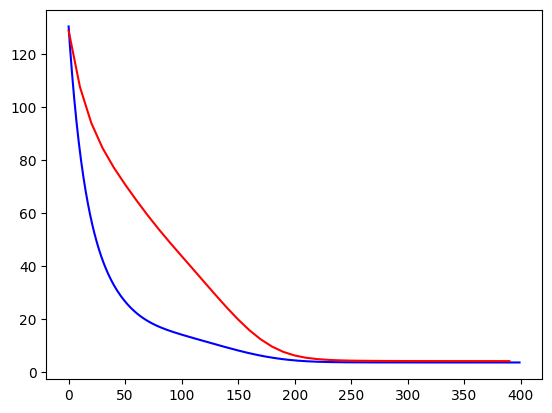

In [104]:
from matplotlib import pyplot as plt
plt.plot(losses_train[:400], color='b')
plt.plot(np.arange(0,400,10), losses_val[:40], color='r')

In [122]:
((torch.round(.detach().numpy()==y_test).mean()

0.37733333333333335

In [130]:
(model(torch.tensor(X_test)[:,0], torch.tensor(X_test)[:,1])-torch.tensor(y_test)).pow(2).mean()

tensor(1.2603, grad_fn=<MeanBackward0>)

# Include other features

In [8]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [9]:
df_users['user_id'] = df_users['user_id'].astype(int)
df_users['age'] = df_users['age'].astype(int)
df_users['zipcode'] = df_users['zipcode'].map(lambda x: int(x) if x.isdigit() else None)
df_users['zipcode'].fillna(df_users['zipcode'].mean(), inplace=True)

In [10]:
l = list(df_users['occupation'].value_counts().index)
for o in l:
    df_users[o] = 0
    df_users.loc[df_users['occupation']==o, o] = 1
    
l = list(df_users['gender'].value_counts().index)
for g in l:
    df_users[g] = 0
    df_users.loc[df_users['gender']==g, g] = 1

In [11]:
user_scaler = MinMaxScaler()
df_users[['age_trans', 'zipcode_trans']] = user_scaler.fit_transform(df_users[['age', 'zipcode']])
df_users.drop(columns=['age', 'gender', 'occupation', 'zipcode'], inplace=True)

In [12]:
for col in list(df_users.columns)[1:]:
    df_users[col] = df_users[col].astype('float32')

In [13]:
df_items['movie_id'] = df_items['movie_id'].astype(int)
df_items[item_cols[5:]] = df_items[item_cols[5:]].astype(int)
df_items.drop(columns=item_cols[1:5], inplace=True)
for col in list(df_items.columns)[1:]:
    df_items[col] = df_items[col].astype('float32')

In [14]:
df_train = df_train.merge(df_users, on='user_id').merge(df_items, on='movie_id')
df_val = df_val.merge(df_users, on='user_id').merge(df_items, on='movie_id')
df_test = df_test.merge(df_users, on='user_id').merge(df_items, on='movie_id')

f_list = list(df_train.columns[4:])
z_train = np.array(df_train[f_list])
z_val = np.array(df_val[f_list])
z_test = np.array(df_test[f_list])

## prepare batch dataset

In [15]:
def prep_batch_dataset2(X, z, y, batch_size):
    dataset2 = TensorDataset(torch.tensor(X), torch.tensor(z), torch.tensor(y.reshape((-1,1))))
    return DataLoader(dataset2, batch_size)

In [16]:
batch_size = 1024
dl2_train = prep_batch_dataset2(X_train, z_train, y_train, batch_size)
dl2_val = prep_batch_dataset2(X_val, z_val, y_val, batch_size)
dl2_test = prep_batch_dataset2(X_test, z_test, y_test, batch_size)

# Model

In [35]:
from collections import OrderedDict
class DNN(nn.Module):
    def __init__(self, n_users, n_items, embedding_dims, hidden_dims, dropout_prob):
        def init_weights(m):
            if type(m) in [nn.Linear, nn.LazyLinear]:
                torch.nn.init.xavier_uniform(m.weight)
                m.bias.data.fill_(0.01)
            
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.user_embedding = nn.Embedding(self.n_users, embedding_dims['user'])
        self.item_embedding = nn.Embedding(self.n_items, embedding_dims['item'])
        self.dense_layers = []
        for i in range(len(hidden_dims)):
            self.dense_layers.append((f"linear{i}", nn.LazyLinear(hidden_dims[i])))
            self.dense_layers.append((f"BatchNorm{i}", nn.LazyBatchNorm1d()))
            self.dense_layers.append((f"Relu{i}", nn.ReLU()))
            self.dense_layers.append((f"Dropout{i}", nn.Dropout(dropout_prob)))
        self.dense_layers = nn.Sequential(OrderedDict(self.dense_layers))
        # self.dense_layers.apply(init_weights)
        self.final_layer = nn.LazyLinear(1)
        
    
        
    def forward(self, user, item, z):
        out = torch.concat((self.user_embedding(user), self.item_embedding(item), z), dim=1)
        out = self.dense_layers(out)
        out = self.final_layer(out)
        return out
        

In [36]:
model2 = DNN(n_users+1, n_items+1, {'user': 50, 'item': 50}, [128, 64, 64, 16], 0.2)

In [37]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model2.parameters(), lr=0.001)

In [52]:
alpha = 0.5
def train(train_dl, val_dl, test_dl, n_epochs, optimizer, print_every=10):
    epoch_loss_train = []
    epoch_mse_train = []
    epoch_mse_val = []
    for i in range(n_epochs):
        batch_loss_train = []
        batch_mse_train = []
        for _, (x,z,y) in enumerate(train_dl):
            optimizer.zero_grad()
            y_pred = model2(x[:,0], x[:,1], z)
            mse_loss = loss_fn(y_pred, y) 
            loss = loss_fn(y_pred, y) 
            loss += alpha*torch.norm(model2.user_embedding(torch.tensor(range(model2.n_users))), dim=1).mean()
            loss += alpha*torch.norm(model2.item_embedding(torch.tensor(range(model2.n_items))), dim=1).mean() 
            loss.backward()
            optimizer.step()
            batch_loss_train.append(loss.item())
            batch_mse_train.append(mse_loss.item())
        epoch_loss_train.append(np.array(batch_loss_train).mean())
        epoch_mse_train.append(np.array(batch_mse_train).mean())
        
        if i % print_every==0:
            batch_mse_val = []
            for _, (x,z,y) in enumerate(val_dl):
                y_pred = model2(x[:,0], x[:,1], z)
                mse_loss = loss_fn(y_pred, y)
                batch_mse_val.append(mse_loss.item())
            # print(batch_mse_train, batch_mse_val)
            epoch_mse_val.append(np.array(batch_mse_val).mean())
            print(f"Iteration {i}, Train loss = {round(epoch_loss_train[-1],4)}, Train MSE = {round(epoch_mse_train[-1],4)}, Validation MSE = {round(epoch_mse_val[-1],4)}")
            if len(epoch_mse_val)>2 and epoch_mse_val[-1] - epoch_mse_val[-2] > 0.01:
                print(f"Early Stopped at iteration {i}, Validation loss increase.")
                break
            
    return epoch_loss_train, epoch_mse_train, epoch_mse_val
                
    

In [53]:
loss_train, mse_train, mse_val = train(dl2_train, dl2_val, dl2_test, 1000, opt)

Iteration 0, Train loss = 2.0063, Train MSE = 0.8526, Validation MSE = 1.2027
Iteration 10, Train loss = 1.7721, Train MSE = 0.8009, Validation MSE = 1.1997
Iteration 20, Train loss = 1.5934, Train MSE = 0.7497, Validation MSE = 1.232
Early Stopped at iteration 20, Validation loss increase.


In [54]:
(model2(torch.tensor(X_test)[:,0], torch.tensor(X_test)[:,1], torch.tensor(z_test))-torch.tensor(y_test)).pow(2).mean()

tensor(1.9757, grad_fn=<MeanBackward0>)